# Move LOFAR array to Inyarrimanha Ilgari Bundara (MRO)
Sometimes it's useful to compare different instruments at the same location. This means you can use exactly the same observational settings and sky models. In this example, we will move the LOFAR array from the Netherlands and stick it into Western Australia, home of the MWA.

This is easy with most primary beam models used in `WODEN`, but `EveryBeam` `LOFAR` models are different. `EveryBeam` read inputs from a measurement set. It not only reads the array layout, but also directional normalisations that setup a faux-zenith for all beams. These directional normalisations (and array coords) are written in Earth-centred Earth-fixed (ECEF) coordinates. This means rather than just changing a central latitude and longitude, you have to rotate everything to a new location. Furthermore, you have to write all this out to a new measurement set, to be read back into `EveryBeam`. There might be a smarter way to do this in memory, but I can't figure it out.

I've done my best to implement these rotations via the function `wodenpy.primary_beam.use_everybeam.create_filtered_ms`. I know for a fact that this isn't correct for remote LOFAR stations. If you plan on using this functionality, please see my notes as written into the documentation of the function. I'll touch again on how things are a little different in the below. 

## Checking the primary beam response
We'll start by checking the az/za response of the LOFAR primary beam in the Netherlands, using an example measurement set. We'll the create a copy of this measurement set, moving it to the MRO. We'll see whether the az/za response is the same, which should be true if we've done our job correctly. 

In [43]:
from subprocess import call
from astropy.io import fits
import numpy as np
from astropy.table import Column, Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from astropy import units as u
import matplotlib.pyplot as plt
import numpy.testing as npt
from astropy.constants import c
from astropy.wcs import WCS
import erfa

from wodenpy.primary_beam.use_everybeam import run_everybeam_over_threads, create_filtered_ms

C = c.to('m/s').value

# ra0 = 0
# dec0 = 53

lofar_lat = 52.905329712
lofar_long = 6.867996528

mwa_lat = -26.703319
mwa_long = 116.670000

lofar_location = EarthLocation(lat=lofar_lat*u.deg, 
                               lon=lofar_long*u.deg)

mwa_location = EarthLocation(lat=mwa_lat*u.deg,
                             lon=mwa_long*u.deg)

OK. We want to get some basic observational settings from our base measurement set. I'm going to reveal an ugly `WODEN` truth here. Depending on your casacore versions, you can get horrific conflicts between `python-casacore`, and whatever `casacore` you linked `EveryBeam` and/or `WODEN` against. When using `run_everybeam_over_threads`, I load in a dynmaic library which is compiled against `casacore`, called `libwoden_double.so`, via the `ctypes` module. If that version of `casacore` is different to whatever `python-casacore` is using, you can get a segfault. `python-casacore` is super handy however. To get rid of these conflicys, I launch everything in separate processes, using `multiprocessing`. This is annoying but it works.

By the by, if you've done something like `pip install casacore` combined with `sudo apt install casacore`, things seems to magically work. Must have mathcing versions?

In [ ]:
def worker_get_ms_settings(ms_path, q):
    """
    Worker function to extract settings from the MS.
    """
    from casacore.tables import table
    with table(ms_path) as ms:
        time_col = ms.getcol("TIME")
        first_time = time_col[0]
        
    with table(base_ms_path+'::FIELD') as field_table:
        phase = np.squeeze(field_table.getcol('REFERENCE_DIR'))
        
    q.put((first_time, phase))
        
    return 

base_ms_path = "../../test_installation/everybeam/LOFAR_HBA_MOCK.ms"
from multiprocessing import Queue, Process
q = Queue()
p = Process(target=worker_get_ms_settings, args=(base_ms_path, q,))
p.start()
p.join()

first_time, phase = q.get()

p.terminate()


observing_time = Time(first_time*u.s, format='mjd', scale='utc',
                      location=lofar_location)

date = observing_time.datetime.strftime('%Y-%m-%dT%H:%M:%S')
    
# print(observing_time)
print(date)
# print(np.degrees(phase))


LST = observing_time.sidereal_time('mean')
lst_deg = LST.to_value(u.deg)
print(f"LST: {lst_deg} deg")

Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms: 24 columns, 2485 rows
Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms::FIELD: 10 columns, 1 rows
2015-01-28T20:14:38
LST: 78.29790192030146 deg


First, make a grid of azminuth / zenith angles to plot. We can convert these into RA/Dec, which is what our EveryBeam function takes.

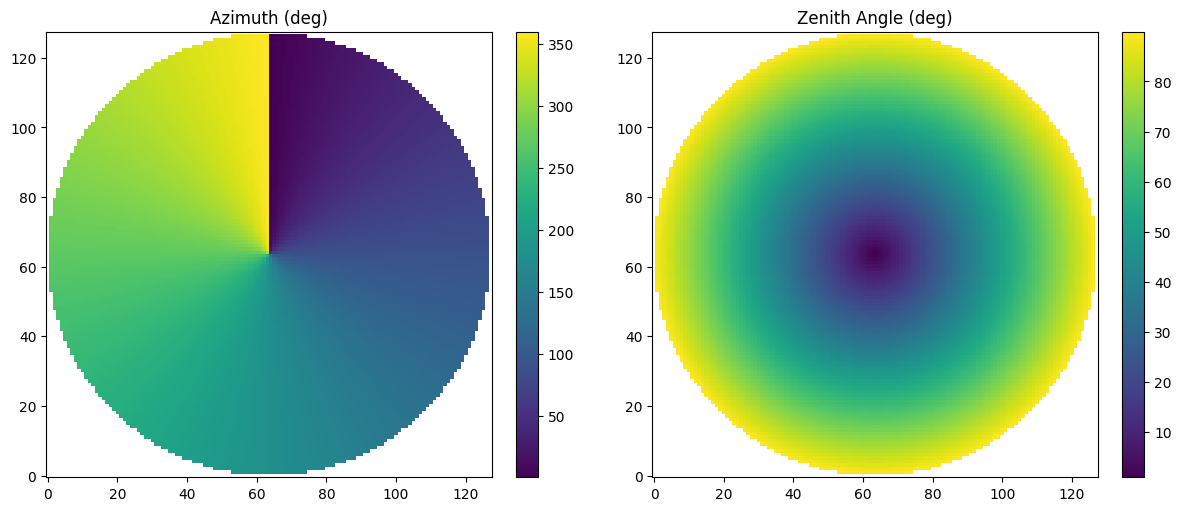

In [79]:
nside = 128
xcoords = np.linspace(-1, 1, nside)
ycoords = np.linspace(-1, 1, nside)
xcoords, ycoords = np.meshgrid(xcoords, ycoords)
za = np.sqrt(xcoords**2 + ycoords**2)*np.pi/2
az = np.pi/2 - np.arctan2(ycoords, xcoords)

az[az < 0] += 2*np.pi

below_horizon = za > np.pi/2
az[below_horizon] = np.nan
za[below_horizon] = np.nan

fig, axs = plt.subplots(1,2, figsize=(12, 5), layout='constrained') 

im = axs[0].imshow(np.degrees(az), origin='lower')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(np.degrees(za), origin='lower')
plt.colorbar(im, ax=axs[1])
axs[0].set_title('Azimuth (deg)')
axs[1].set_title('Zenith Angle (deg)')
plt.show()

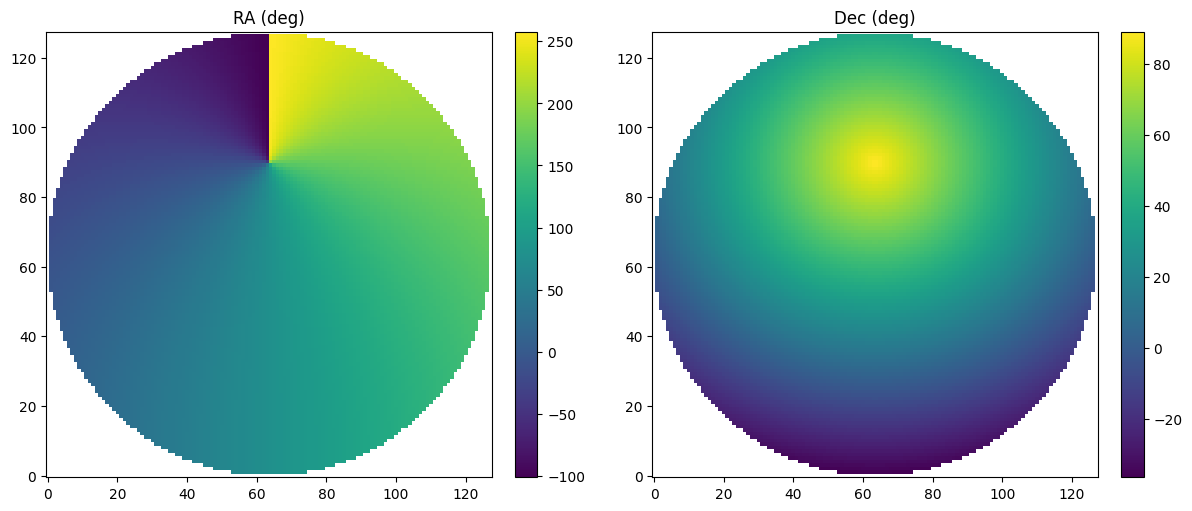

In [80]:
has, decs = erfa.ae2hd(az, np.pi/2-za, np.radians(lofar_lat))

ras = np.radians(lst_deg) - has

fig, axs = plt.subplots(1,2, figsize=(12, 5), layout='constrained') 

im = axs[0].imshow(np.degrees(ras), origin='lower')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(np.degrees(decs), origin='lower')
plt.colorbar(im, ax=axs[1])
axs[0].set_title('RA (deg)')
axs[1].set_title('Dec (deg)')
plt.show()

I'm going to run the primary beam with `parallactic_rotate=False`. This is because the parallactic rotation depends on the latitude of the array, so we'll never get a match when comparing the two arrays that way.

In [81]:
##don't bother precessing the array back to j2000 for this test. Just whack in
##current values
j2000_latitudes = [np.radians(lofar_lat)]
j2000_lsts = [np.radians(lst_deg)]
times = [observing_time]
freqs = [150e+6]
station_ids = [0, 69]
##Everybeam doesn't need a coeff path for this beam
coeff_path=""

##We'll run EveryBeam in parallel to speed things up
num_threads=8

all_jones_orig = run_everybeam_over_threads(num_threads, base_ms_path,
                            coeff_path,
                            ras.flatten(), decs.flatten(),
                            phase[0], phase[1],
                            j2000_latitudes, j2000_lsts,
                            times, freqs, station_ids,
                            apply_beam_norms=True,
                            iau_order=True,
                            parallactic_rotate=False)

Thread 0 processing coords 0 to 2048Thread 1 processing coords 2048 to 4096
Thread 2 processing coords 4096 to 6144

Thread 3 processing coords 6144 to 8192
Thread 4 processing coords 8192 to 10240
Thread 5 processing coords 10240 to 12288Thread 6 processing coords 12288 to 14336Thread 7 processing coords 14336 to 16384


Thread 2 finished
Thread 1 finished
Thread 3 finished
Thread 4 finished
Thread 0 finished
Thread 5 finished
Thread 6 finished
Thread 7 finished


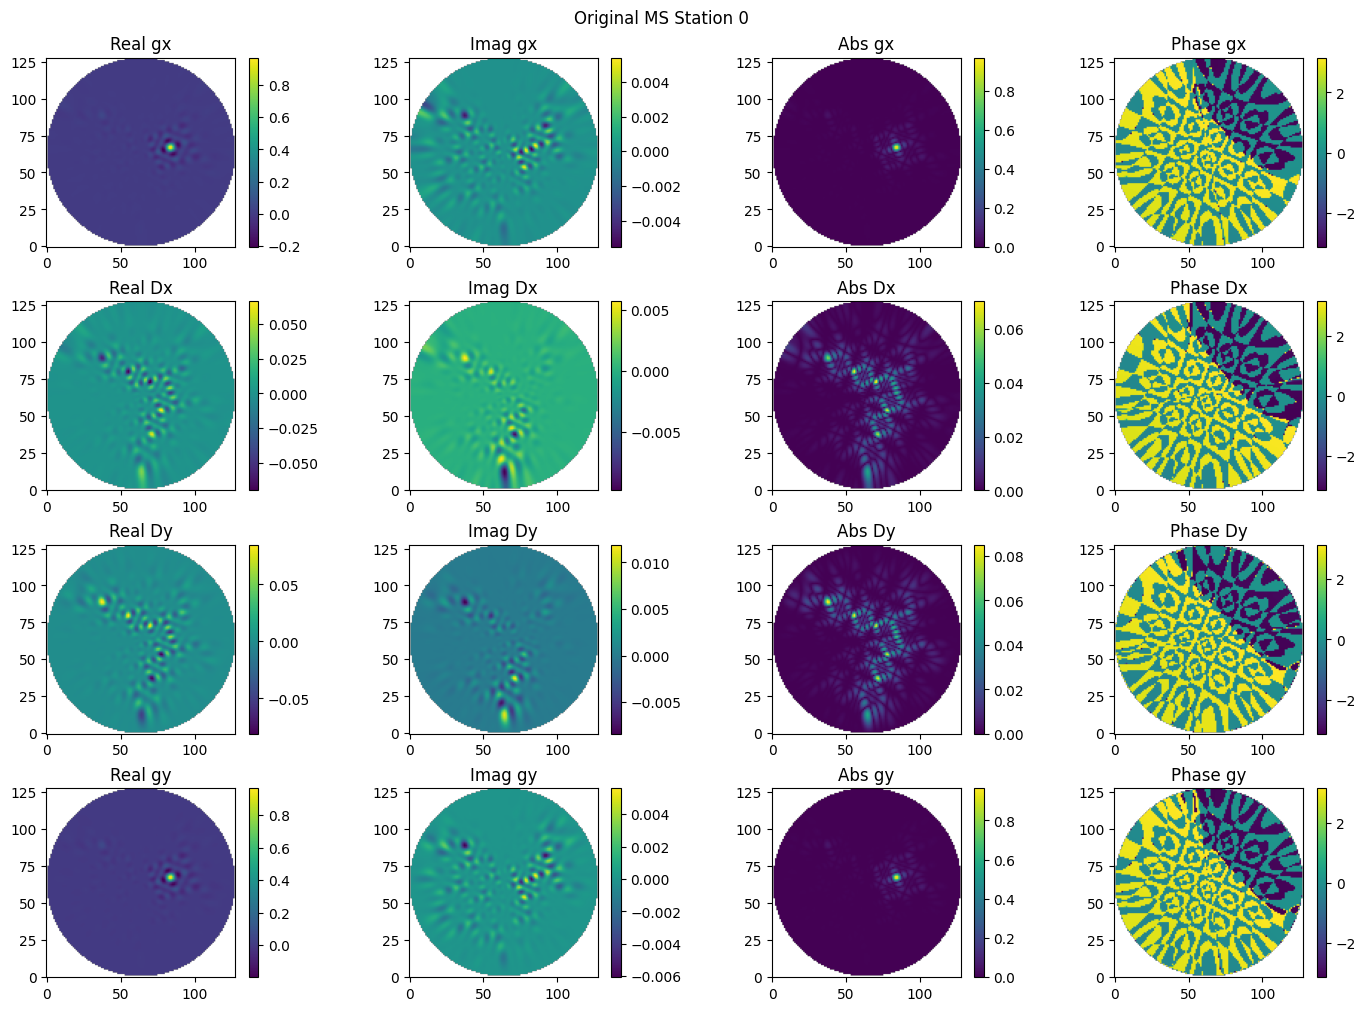

In [82]:
def plot_jones(all_jones, station_ind, title, nside):
    
    fig, axs = plt.subplots(4, 4, figsize=(14, 10), layout='constrained')
    
    gx = all_jones[station_ind, 0, 0, :, 0, 0]
    Dx = all_jones[station_ind, 0, 0, :, 1, 0]
    Dy = all_jones[station_ind, 0, 0, :, 0, 1]
    gy = all_jones[station_ind, 0, 0, :, 1, 1]
    
    ax = 0
    for pol, label in zip([gx, Dx, Dy, gy], ['gx', 'Dx', 'Dy', 'gy']):
        
        pol = pol.reshape((nside, nside))
        
        im = axs[ax, 0].imshow(np.real(pol), origin='lower')
        axs[ax, 0].set_title(f'Real {label}')
        plt.colorbar(im, ax=axs[ax, 0])
        im = axs[ax, 1].imshow(np.imag(pol), origin='lower')
        axs[ax, 1].set_title(f'Imag {label}')
        plt.colorbar(im, ax=axs[ax, 1])
        im = axs[ax, 2].imshow(np.abs(pol), origin='lower')
        axs[ax, 2].set_title(f'Abs {label}')
        plt.colorbar(im, ax=axs[ax, 2])
        im = axs[ax, 3].imshow(np.angle(pol), origin='lower')
        axs[ax, 3].set_title(f'Phase {label}')
        plt.colorbar(im, ax=axs[ax, 3])
        
        ax += 1
        
    plt.suptitle(f'{title} Station {station_ind}')
    
plot_jones(all_jones_orig, 0, 'Original MS', nside)

OK. Now let's create a copy of the measurement set, moving it to the MRO. We'll use the `create_filtered_ms` function to do this. 

In [83]:
new_ms_path = "LOFAR_HBA_at_MRO.ms"


##We want an equivalent phase centre. So find the az,el of original phase centre
##and convert that the HA,Dec at the MRO.

obs_time_mwa = Time(first_time*u.s, format='mjd', scale='utc',
                    location=mwa_location)

lst_mwa_rad = obs_time_mwa.sidereal_time('mean').to_value(u.rad)

orig_ha = np.radians(lst_deg) - phase[0]
if orig_ha < 0: orig_ha += 2 * np.pi
    
orig_point_az, orig_point_el = erfa.hd2ae(orig_ha, phase[1], np.radians(lofar_lat))

ha0_mwa, dec0_mwa = erfa.ae2hd(orig_point_az, orig_point_el, np.radians(mwa_lat))
ra0_mwa = lst_mwa_rad - ha0_mwa

print(f"New RA0: {np.degrees(ra0_mwa)} deg")
print(f"New Dec0: {np.degrees(dec0_mwa)} deg")

create_filtered_ms(base_ms_path, new_ms_path,
                       ra0_mwa, dec0_mwa,
                       recentre_array=True,
                       current_latitude=np.radians(lofar_lat),
                       current_longitude=np.radians(lofar_long),
                       new_latitude=np.radians(mwa_lat),
                       new_longitude=np.radians(mwa_long))

New RA0: 218.07668609589345 deg
New Dec0: -19.15318534756807 deg
Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms: 24 columns, 2485 rows
Successful read/write open of default-locked table LOFAR_HBA_at_MRO.ms::FIELD: 10 columns, 1 rows
Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms/ANTENNA: 10 columns, 70 rows
Successful read/write open of default-locked table LOFAR_HBA_at_MRO.ms::ANTENNA: 10 columns, 70 rows
Successful read/write open of default-locked table LOFAR_HBA_at_MRO.ms::LOFAR_ANTENNA_FIELD: 9 columns, 70 rows
Successful read/write open of default-locked table LOFAR_HBA_at_MRO.ms::LOFAR_ANTENNA_FIELD: 9 columns, 70 rows


OK, this should have made a new measurement set in the MRO, called `LOFAR_HBA_at_MRO.ms`. Let's make some new RA/Dec coords and see what the beam looks like.

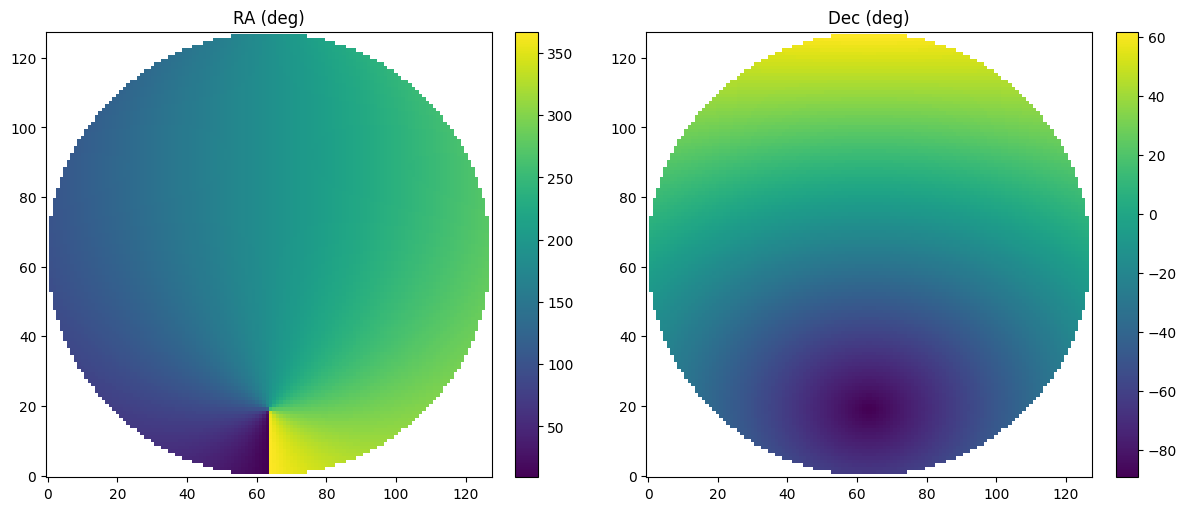

In [84]:
mwa_has, mwa_decs = erfa.ae2hd(az, np.pi/2-za, np.radians(mwa_lat))

mwa_ras = lst_mwa_rad - mwa_has

fig, axs = plt.subplots(1,2, figsize=(12, 5), layout='constrained') 

im = axs[0].imshow(np.degrees(mwa_ras), origin='lower')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(np.degrees(mwa_decs), origin='lower')
plt.colorbar(im, ax=axs[1])
axs[0].set_title('RA (deg)')
axs[1].set_title('Dec (deg)')
plt.show()

In [85]:
##don't bother precessing the array back to j2000 for this test. Just whack in
##current values
j2000_latitudes = [np.radians(mwa_lat)]
j2000_lsts = [lst_mwa_rad]
times = [obs_time_mwa]
freqs = [150e+6]
station_ids = [0, 69]
##Everybeam doesn't need a coeff path for this beam
coeff_path=""

##We'll run EveryBeam in parallel to speed things up
num_threads=8

all_jones_mwa = run_everybeam_over_threads(num_threads, new_ms_path,
                            coeff_path,
                            mwa_ras.flatten(), mwa_decs.flatten(),
                            ra0_mwa, dec0_mwa,
                            j2000_latitudes, j2000_lsts,
                            times, freqs, station_ids,
                            apply_beam_norms=True,
                            iau_order=True,
                            parallactic_rotate=False)

Thread 0 processing coords 0 to 2048Thread 1 processing coords 2048 to 4096

Thread 2 processing coords 4096 to 6144Thread 3 processing coords 6144 to 8192

Thread 4 processing coords 8192 to 10240Thread 5 processing coords 10240 to 12288
Thread 6 processing coords 12288 to 14336
Thread 7 processing coords 14336 to 16384

Thread 3 finished
Thread 4 finished
Thread 2 finished
Thread 0 finished
Thread 7 finished
Thread 6 finished
Thread 5 finished
Thread 1 finished


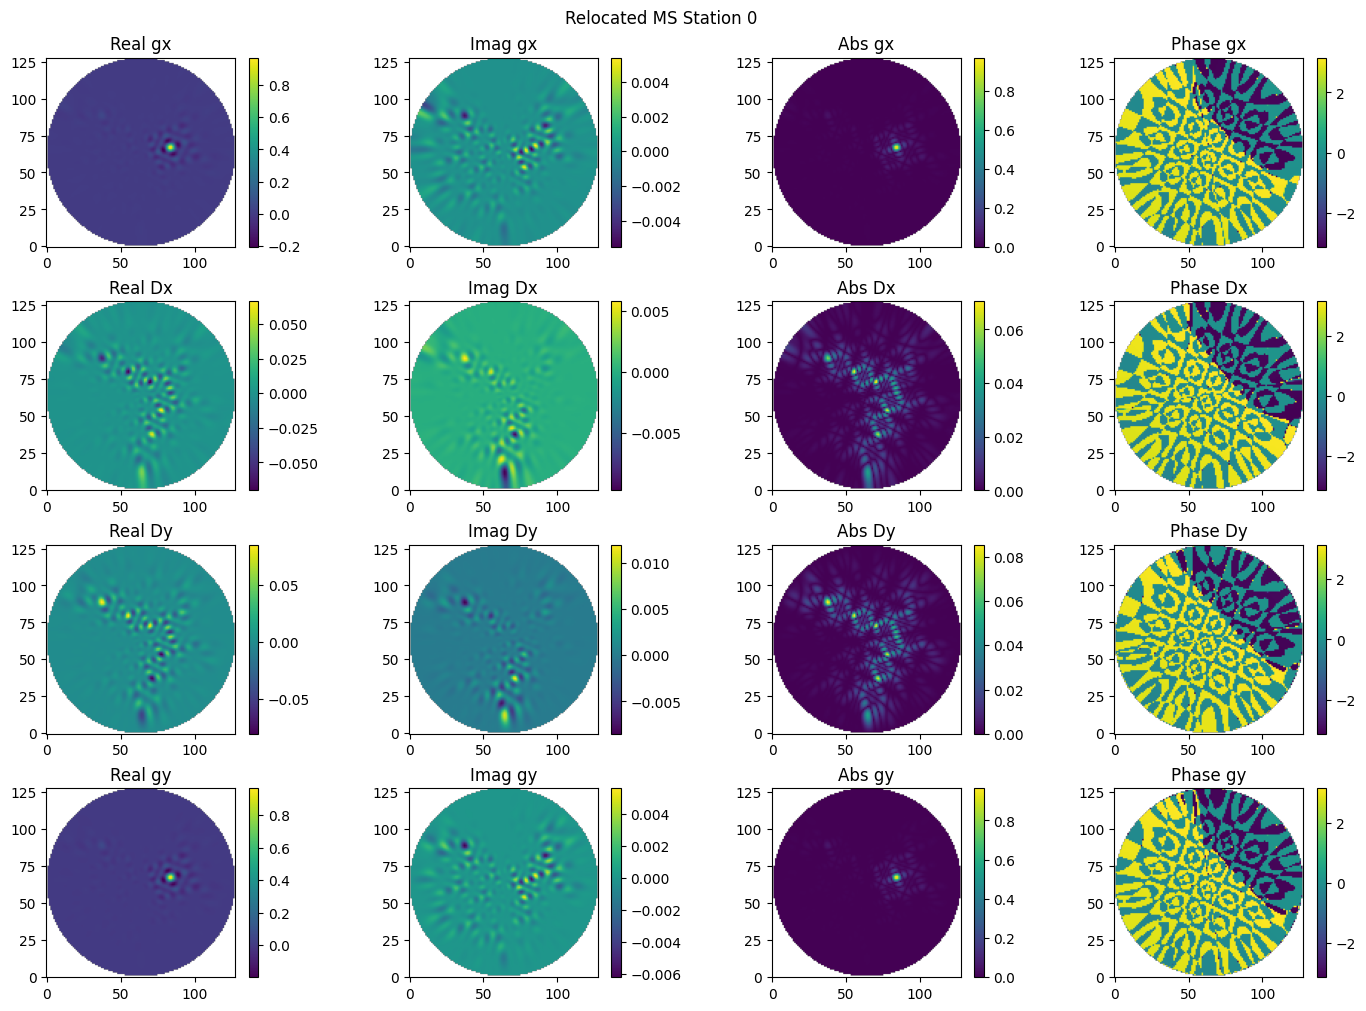

In [86]:
plot_jones(all_jones_mwa, 0, 'Relocated MS', nside)

Look's good by eye. Let's do a proper comparison:

In [108]:
atol = 6e-2

is_close = np.allclose(all_jones_orig[0, 0, 0, :, :, :],
                    all_jones_mwa[0, 0, 0, :, :, :],
                    atol=atol, equal_nan=True)

print(f"Are the Jones matrices within absolute tolerance of {atol:.2e}? {is_close}")

Are the Jones matrices within absolute tolerance of 6.00e-02? True


Are the Jones matrices within abs tolerance of 6.00e-02? True


/tmp/ipykernel_3452641/3343391057.py:17: RuntimeWarning: divide by zero encountered in log
  im = axs[0].imshow(np.log(np.abs(gx_lofar)), origin='lower', vmin=-10, vmax=0)
/tmp/ipykernel_3452641/3343391057.py:20: RuntimeWarning: divide by zero encountered in log
  im = axs[1].imshow(np.log(np.abs(gx_mwa)), origin='lower', vmin=-10, vmax=0)


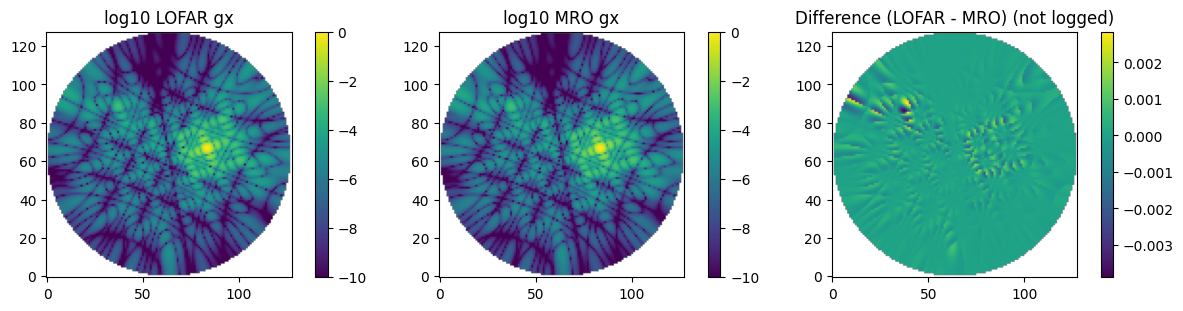

In [ ]:
gx_lofar = all_jones_orig[0, 0, 0, :, 0, 0]
gx_mwa = all_jones_mwa[0, 0, 0, :, 0, 0]

gx_lofar = gx_lofar.reshape((nside, nside))
gx_mwa = gx_mwa.reshape((nside, nside))


fig, axs = plt.subplots(1, 3, figsize=(12, 3), layout='constrained')
im = axs[0].imshow(np.log(np.abs(gx_lofar)), origin='lower', vmin=-10, vmax=0)
plt.colorbar(im, ax=axs[0])
axs[0].set_title('log10 LOFAR gx')
im = axs[1].imshow(np.log(np.abs(gx_mwa)), origin='lower', vmin=-10, vmax=0)
plt.colorbar(im, ax=axs[1])
axs[1].set_title('log10 MRO gx')
im = axs[2].imshow(np.abs(gx_lofar) - np.abs(gx_mwa), origin='lower')
plt.colorbar(im, ax=axs[2])
axs[2].set_title('Difference (LOFAR - MRO) (not logged)')

plt.show()


## Remote LOFAR stations

Righto, the above comparisons were for station 0, which is for a central station. Let's look at station 69, which is a remote one:

In [111]:
atol = 6e-2

is_close = np.allclose(all_jones_orig[1, 0, 0, :, :, :],
                    all_jones_mwa[1, 0, 0, :, :, :],
                    atol=atol, equal_nan=True)

print(f"Are the Jones matrices within absolute tolerance of {atol:.2e}? {is_close}")

Are the Jones matrices within absolute tolerance of 6.00e-02? False


/tmp/ipykernel_3452641/3275169649.py:9: RuntimeWarning: divide by zero encountered in log
  im = axs[0].imshow(np.log(np.abs(gx_lofar)), origin='lower', vmin=-10, vmax=0)
/tmp/ipykernel_3452641/3275169649.py:12: RuntimeWarning: divide by zero encountered in log
  im = axs[1].imshow(np.log(np.abs(gx_mwa)), origin='lower', vmin=-10, vmax=0)


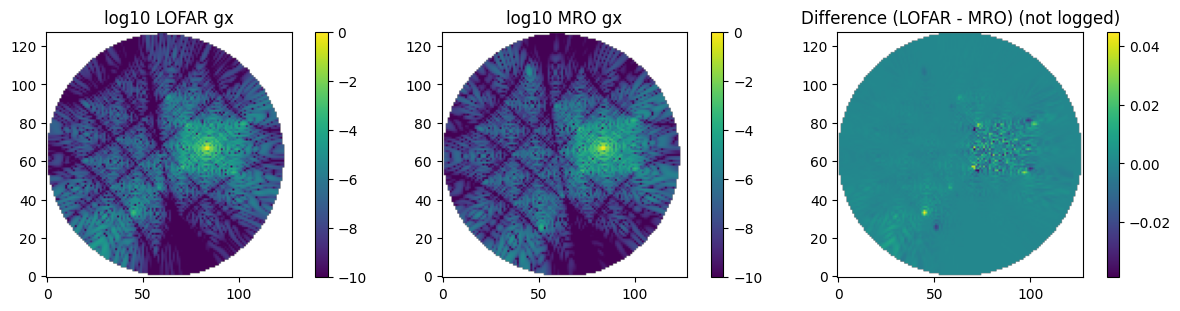

In [110]:
gx_lofar = all_jones_orig[1, 0, 0, :, 0, 0]
gx_mwa = all_jones_mwa[1, 0, 0, :, 0, 0]

gx_lofar = gx_lofar.reshape((nside, nside))
gx_mwa = gx_mwa.reshape((nside, nside))


fig, axs = plt.subplots(1, 3, figsize=(12, 3), layout='constrained')
im = axs[0].imshow(np.log(np.abs(gx_lofar)), origin='lower', vmin=-10, vmax=0)
plt.colorbar(im, ax=axs[0])
axs[0].set_title('log10 LOFAR gx')
im = axs[1].imshow(np.log(np.abs(gx_mwa)), origin='lower', vmin=-10, vmax=0)
plt.colorbar(im, ax=axs[1])
axs[1].set_title('log10 MRO gx')
im = axs[2].imshow(np.abs(gx_lofar) - np.abs(gx_mwa), origin='lower')
plt.colorbar(im, ax=axs[2])
axs[2].set_title('Difference (LOFAR - MRO) (not logged)')

plt.show()


You can see that there is a rotational / alignment issue here. This is because the remote `LOFAR` stations are far enough away that the curvature of the Earth starts pointing the "up" of each set of dipoles in different directions. There are a set of basis functions assocaited with each station in the measurement set. The central ones are all referenced to the same "up", but the remote ones are aligned with something parallel to the station centre. The exact calculation that `LOFAR` does to work this out is beyond me. If you need to fix this, check out the function `wodenpy.primary_beam.use_everybeam.calc_coordinate_axes` which does this rotation. I've left notes on what needs to be done in there.

For most users, I think this is good enough though. The use case I see here is seeing how a LOFAR-style array would look at the MRO, and comparing it to the MWA. The mean patter is certainly similar enough that a far comparison can be made.

## Compare uvw
OK, let's run two super lightweight simulations, both phased to zenith, and compare the uvw coordinates. This is a good test to see whether the array has been moved correctly. I'm going to be lazy and make an old-school text sky model for each. It'll just be a single point source at the zenith.

Note I'm being careful here. I've set the time resolution to 0.01s, and turned off array precession. This is because when moving the array to different latitudes, precession is different, and depending on where the phase centre is, the relative hour angle / declination offset between phase centre and zenith changes at a different rate. As `u,v,w` coords depend on these things, they will only match for this initial setup.

In [195]:
with open("lofar_zenith.txt", "w") as f:
    f.write(f"SOURCE lofar_zenith P 1 G 0 S 0 0\n")
    f.write(f"COMPONENT POINT {lst_deg/15.0} {lofar_lat}\n")
    f.write(f"LINEAR 180e+6 1.0 0 0 0 0.0\n")
    f.write("ENDCOMPONENT\n")
    f.write("ENDSOURCE\n")

cmd = "run_woden.py "
cmd += f"--ra0={lst_deg} --dec0={lofar_lat} "
cmd += f"--num_freq_channels=1 --num_time_steps=1 "
cmd += f"--freq_res=80e+3 --time_res=0.01 "
cmd += f"--cat_filename=lofar_zenith.txt "
cmd += f"--date={date} --lowest_channel_freq=167.035e+6 "
cmd += f"--coarse_band_width=1.28e+6 "
cmd += f"--band_nums=1 "
cmd += f"--output_uvfits_prepend=lofar_at_lofar "
cmd += f"--primary_beam=everybeam_LOFAR "
cmd += f"--num_threads=2 --cpu_mode "
cmd += f"--beam_ms_path={base_ms_path} "
cmd += f"--no_precession "

call(cmd, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms: 24 columns, 2485 rows
Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful read/write open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms::FIELD: 10 columns, 1 rows
Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms/ANTENNA: 10 columns, 70 rows
2025-05-27 08:53:23 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ 

2025-05-26 22:53:25	INFO	MeasIERS::fillMeas(MeasIERS::Files, Double) 	Requested JD 3.56732e-315 is outside the range of the IERS (Earth axis data) table.
2025-05-26 22:53:25	INFO	MeasIERS::fillMeas(MeasIERS::Files, Double) +	Calculations will proceed with less precision


2025-05-27 08:53:24 - INFO - Full run took 0:00:01.693635
2025-05-27 08:53:24 - INFO - WODEN is done. Closing the log. S'later


0

Aight now do it for the MRO case. Note instead of using the `LOFAR_HBA_at_MRO.ms` measurement set, I'll use the arguments `--move_array_to_latlon`, which will move the array to the specified `--latitude` and `--longitude`, and `--eb_ra_point, --eb_dec_point` to control the pointing direction. This will be written into a temporary lightweight measurement set, which will be deleted after the run.

In [196]:
use_lat = mwa_lat

with open("mro_zenith.txt", "w") as f:
    f.write(f"SOURCE mro_zenith P 1 G 0 S 0 0\n")
    f.write(f"COMPONENT POINT {np.degrees(lst_mwa_rad)/15.0} {use_lat}\n")
    f.write(f"LINEAR 180e+6 1.0 0 0 0 0.0\n")
    f.write("ENDCOMPONENT\n")
    f.write("ENDSOURCE\n")

cmd = "run_woden.py "
cmd += f"--ra0={np.degrees(lst_mwa_rad)} --dec0={use_lat} "
cmd += f"--latitude={use_lat} --longitude={mwa_long} "
cmd += f"--num_freq_channels=1 --num_time_steps=1 "
cmd += f"--freq_res=80e+3 --time_res=0.01 "
cmd += f"--cat_filename=mro_zenith.txt "
cmd += f"--date={date} --lowest_channel_freq=167.035e+6 "
cmd += f"--coarse_band_width=1.28e+6 "
cmd += f"--band_nums=1 "
cmd += f"--output_uvfits_prepend=lofar_at_mro "
cmd += f"--primary_beam=everybeam_LOFAR "
cmd += f"--num_threads=2 --cpu_mode "
cmd += f"--beam_ms_path={base_ms_path} "
cmd += f"--move_array_to_latlon "
cmd += f"--eb_ra_point={np.degrees(ra0_mwa)} "
cmd += f"--eb_dec_point={np.degrees(dec0_mwa)} "
cmd += f"--no_precession "

call(cmd, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms: 24 columns, 2485 rows
Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful read/write open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms::FIELD: 10 columns, 1 rows
Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms: 24 columns, 2485 rows
Successful read/write open of default-locked table /home/jack-line/software/WODEN_dev/examples/relocate_everybeam_array/pointed_lofar_at_mro_band01.ms::FIELD: 10 columns, 1 rows
Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms/ANTENNA: 10 columns, 70 rows
Successful read/write open of default-locked table /home/jack-line/software/WODEN_dev/examples/relocate_everybeam_array/pointed_lofar_at_mro_band01.ms::ANTENNA: 10 columns, 70 r

2025-05-26 22:53:38	INFO	MeasIERS::fillMeas(MeasIERS::Files, Double) 	Requested JD 4.57183e-315 is outside the range of the IERS (Earth axis data) table.
2025-05-26 22:53:38	INFO	MeasIERS::fillMeas(MeasIERS::Files, Double) +	Calculations will proceed with less precision


2025-05-27 08:53:38 - INFO - Done
2025-05-27 08:53:38 - INFO - Full run took 0:00:01.953880
2025-05-27 08:53:38 - INFO - WODEN is done. Closing the log. S'later


0

OK, let's compare the uvw coordinates. 

In [197]:
def get_visi_and_uvw(uvfits_path):
    """
    Extract visibility data and UVW coordinates from a UVFITS file.
    """
    with fits.open(uvfits_path) as hdul:
        vis_data = np.squeeze(hdul[0].data.data)
        uu = hdul[0].data['UU']*C
        vv = hdul[0].data['VV']*C
        ww = hdul[0].data['WW']*C
        
    return vis_data, uu, vv, ww


lofar_vis, lofar_uu, lofar_vv, lofar_ww = get_visi_and_uvw("lofar_at_lofar_band01.uvfits")
mro_vis, mro_uu, mro_vv, mro_ww = get_visi_and_uvw("lofar_at_mro_band01.uvfits")

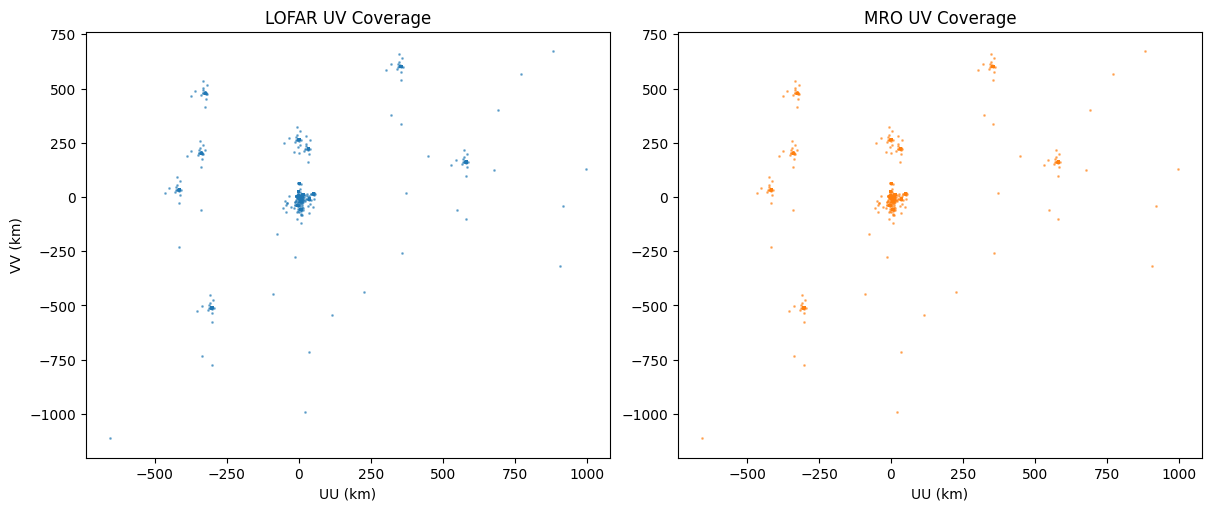

In [198]:

fig, axs = plt.subplots(1, 2, figsize=(12, 5), layout='constrained')
axs[0].scatter(lofar_uu/1e+3, lofar_vv/1e+3, s=1, color='C0', alpha=0.5)
axs[0].set_title('LOFAR UV Coverage')
axs[1].scatter(mro_uu/1e+3, mro_vv/1e+3, s=1, color='C1', alpha=0.5)
axs[1].set_title('MRO UV Coverage')

axs[0].set_xlabel('UU (km)')
axs[1].set_xlabel('UU (km)')
axs[0].set_ylabel('VV (km)')

plt.show()

OK, so roughly look the same by eye. Zooming in:

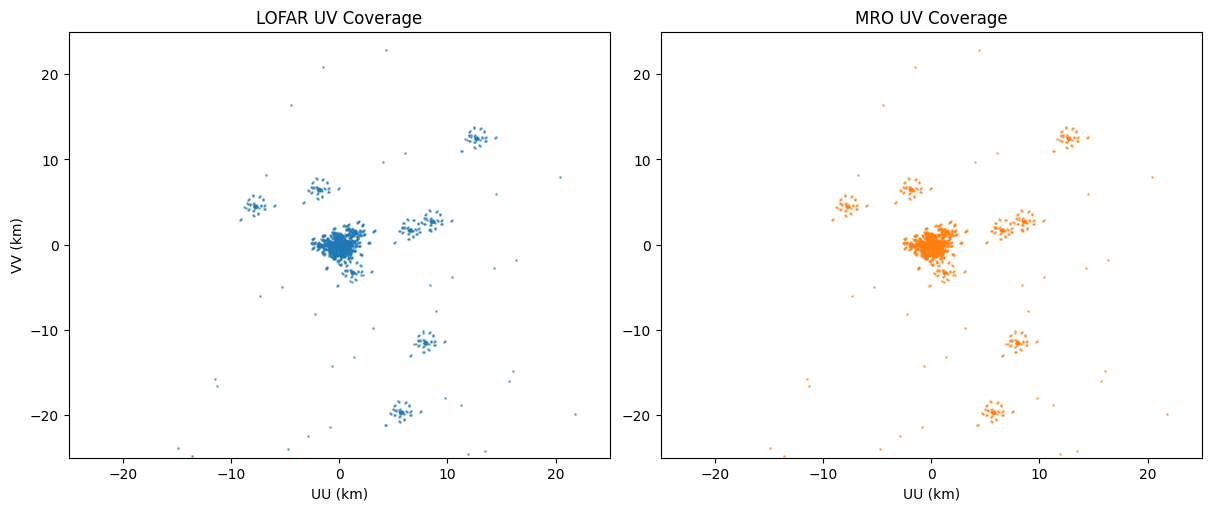

In [199]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), layout='constrained')
axs[0].scatter(lofar_uu/1e+3, lofar_vv/1e+3, s=1, color='C0', alpha=0.5)
axs[0].set_title('LOFAR UV Coverage')
axs[1].scatter(mro_uu/1e+3, mro_vv/1e+3, s=1, color='C1', alpha=0.5)
axs[1].set_title('MRO UV Coverage')

axs[0].set_xlabel('UU (km)')
axs[1].set_xlabel('UU (km)')
axs[0].set_ylabel('VV (km)')

for ax in axs:
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)

plt.show()

Eh they look pretty similar, but let's see how similar they are numerically:

In [211]:
rtol = 1e-3
atol = 1e-2

np.allclose(lofar_uu, mro_uu, atol=atol, rtol=rtol)
np.allclose(lofar_vv, mro_vv, atol=atol, rtol=rtol)
np.allclose(lofar_ww, mro_ww, atol=atol, rtol=rtol)

True

OK, so as the uvw coordinates are currently in metres, this means they come out to be within either 1cm, or within 0.1% of the original value. Which again for a comparison of two arrays at different locations is good enough.